In [46]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [47]:
# Helper (support)
from support import input_helper

In [48]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [49]:
ROOT_DIR = "RawData"

In [50]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale=1)

In [51]:
pd.set_option('precision', 2)

* BE = Belgium
* FR = France
* EU = Europe
* FG = Flat Glass
* ArchFG = Architectural Flat Glass

# Upload Datasets

In [52]:
BE_data = input_helper.get_data('BE_RawData_VPython.xlsx', directory=ROOT_DIR)
FR_data = input_helper.get_data('FR_RawData_VPython.xlsx', directory=ROOT_DIR)
EU_data = input_helper.get_data('EU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [53]:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS', 'Population']

FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'Population', 'workforce', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'RawMat_FlatGlass_ABS', 'emissions']

EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs']



# Flat Glass Production in Europe

## Creating a Dataframe for Flat Glass Flows

In [54]:
# Data relating to flat glass production
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [55]:
# Adding import and export flows
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

In [56]:
# Creating a single dataframe for flat glass flows in Europe
EU = pd.concat([EU_Prod['flat glass, kt'],
                EU_Imp['flat glass, kt'],
                EU_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]'),
                                ('Import [kt]'),
                                ('Export [kt]')],
                  names=['Flow']).stack(dropna=False)

EU = EU.unstack()

In [57]:
EU

Flow                   Production [kt]  Import [kt]  Export [kt]
Nbr of countries year                                           
6                1945              NaN          NaN          NaN
                 1946              NaN          NaN          NaN
                 1947              NaN          NaN          NaN
                 1948              NaN          NaN          NaN
                 1949              NaN          NaN          NaN
...                                ...          ...          ...
28               2015           9641.0      1079.10      1187.54
                 2016           9835.0      1255.01      1192.21
                 2017          10665.0      1534.99      1158.69
                 2018          10643.0      1673.63      1178.92
                 2019          10840.0          NaN          NaN

[77 rows x 3 columns]

## Flat Glass Production

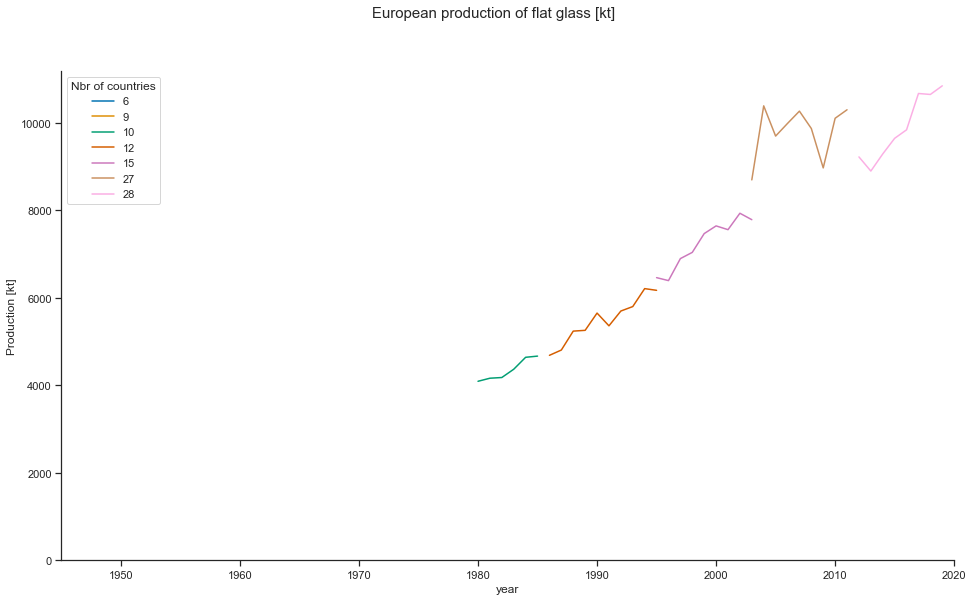

In [58]:
# Plot the European production of flat glass

fig, ax = plt.subplots()

sns.lineplot(data = EU.reset_index(), 
             x = 'year', y = 'Production [kt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of flat glass [kt]', fontsize = 15)
sns.despine()
plt.show()

## Flat Glass Consumption

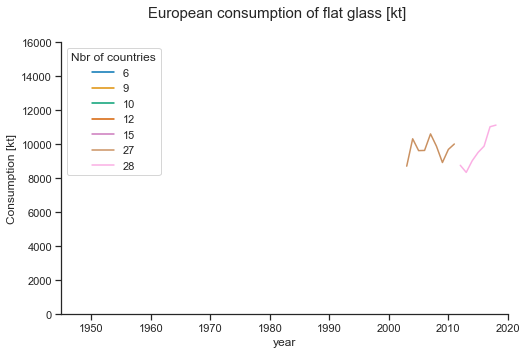

In [59]:
# Estimating consumption in EU
EU['Consumption [kt]'] = (EU['Production [kt]'] 
                          + EU['Import [kt]'] 
                          - EU['Export [kt]']
                         )

# Plotting the European consumption of flat glass

fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data = EU.reset_index(), 
             x = 'year', y = 'Consumption [kt]', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0, 16000)

fig.suptitle('European consumption of flat glass [kt]', fontsize = 15)
sns.despine()
plt.show()

## Architectural Flat Glass Production

In [60]:
# Share of building glazing in the European production of flat glass
EUBldgShare = EU_Prod[['bldg glass/flat glass, %']].copy()

EUBldgShare = EUBldgShare.dropna()

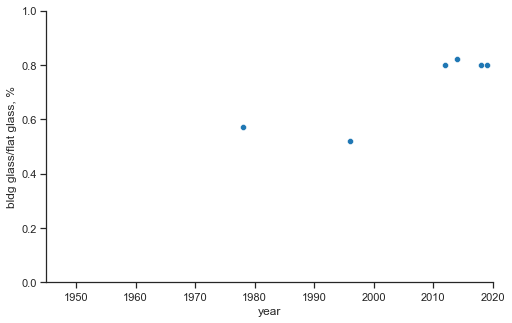

In [61]:
fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(data=EUBldgShare.reset_index(), 
                x='year', y='bldg glass/flat glass, %', 
                markers="o", ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,1)
sns.despine()

In [62]:
# Linear interpolation
EU['bldg glass/flat glass, %'] = (EU_Prod['bldg glass/flat glass, %']
                                       .interpolate(method="linear", 
                                                    limit_area='inside')
                                      )

In [63]:
# Calculation of EU production of architectural flat glass:
EU['Architectural glass production [kt]'] = (EU['Production [kt]']
                                             * EU['bldg glass/flat glass, %']
                                            )

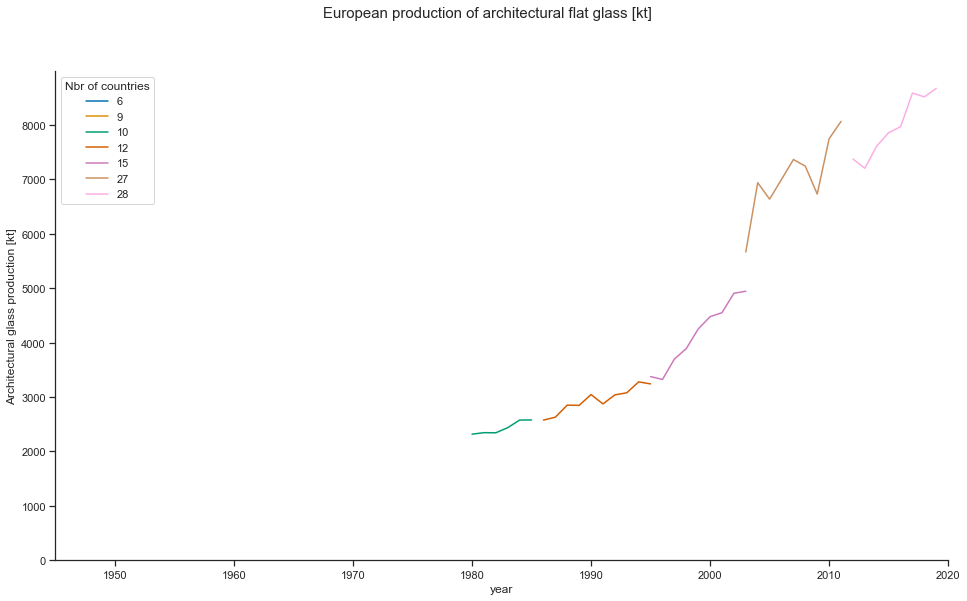

In [64]:
# Plot the European production of architectural flat glass
fig, ax = plt.subplots()

sns.lineplot(data = EU.reset_index(), 
             x = 'year', y = 'Architectural glass production [kt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of architectural flat glass [kt]', 
             fontsize = 15)
sns.despine()
plt.show()

## Summary

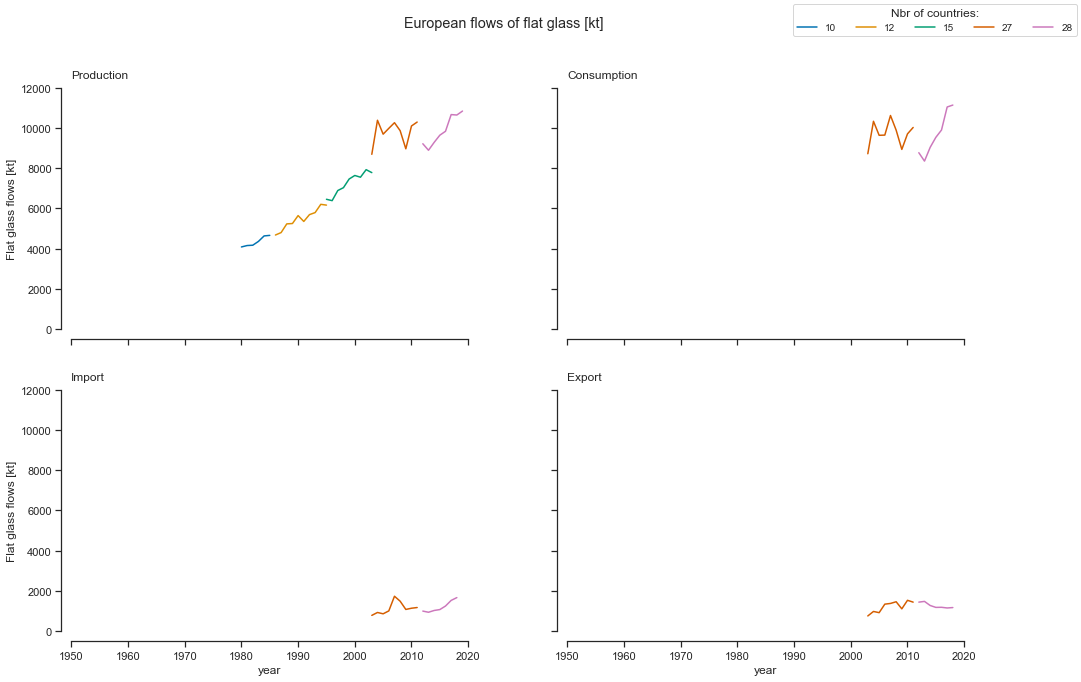

In [209]:
# Plotting import and export flows of flat glass
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16,10))

for col, data in enumerate(data1):
    ax=axes[0][col]
    if col == 0:
        ax.set_ylabel('Flat glass flows [kt]')
    sns.lineplot(data=EU.loc[10:28].reset_index(),
                 x='year', y=f"{data} [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(data, pad=10, loc='left')
    ax.get_legend().remove()
    
for col, data in enumerate(data2):
    ax=axes[1][col]
    if col == 0:
        ax.set_ylabel('Flat glass flows [kt]')
    sns.lineplot(data=EU.loc[10:28].reset_index(),
                 x='year', y=f"{data} [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(data, pad=10, loc='left')
    ax.get_legend().remove()

# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=7, 
          fontsize='10', title='Nbr of countries:')

ax.set_xlim(1950,2020)
ax.set_ylim(0, 12000)

fig.suptitle("European flows of flat glass [kt]")
fig.subplots_adjust(wspace = 0.25, hspace = 0.25)

sns.despine(offset=10)
plt.show()

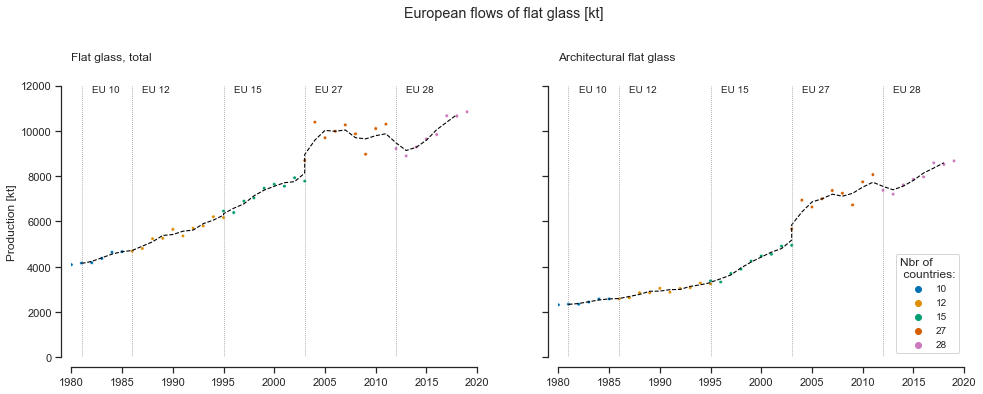

In [173]:
# Plot the European production of flat glass and only arch flat glass:
data = ['Production', 'Architectural glass production']

# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_Kdates = {'EU 10':1981, 'EU 12':1986, 'EU 15':1995, 
             'EU 27':2003, 'EU 28':2012}

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for col, data in enumerate(data):
    ax=axes[col]
    
    # Plot the trend curve for flat glass production:
    ax.plot(EU[f"{data} [kt]"]
        .reset_index(level='Nbr of countries')
        .sort_values(by=['year'])
        .interpolate().rolling(3, center = True)
        .mean()[f"{data} [kt]"],
        linewidth=1.1, c='black', linestyle='--'
       )
    
    # Plot data gathered from literature review and calculated for arch glass:
    sns.scatterplot(data=EU.loc[10:28].reset_index(),
                    x='year', y=f"{data} [kt]",
                    hue = 'Nbr of countries', 
                    palette = 'colorblind',
                    marker='.', s=50,
                    ax=ax)
    ax.set_xlabel(None)
    if col == 0:
        ax.get_legend().remove()
        ax.set_title('Flat glass, total', pad=25, loc='left')
    else:
        ax.set_title('Architectural flat glass', pad=25, loc='left')
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper right', ncol=1, 
                  fontsize='10', title='Nbr of \n countries:',
                  bbox_to_anchor=(1, 0.4))
    
    # Plot lines highlighting changes in the scope, i.e. EU enlargement
    for y, x in EU_Kdates.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+1, 12000, f"{y}",fontsize=10,
                 verticalalignment='top')

ax.set_xlim(1980,2020)
ax.set_ylim(0,12000)

fig.suptitle("European flows of flat glass [kt]", y=1.10)
fig.subplots_adjust(wspace = 0.2)

sns.despine(offset=10, trim=True)
plt.show()

# Flat Glass Production in France and Belgium

## Creating a Dataframe for Flat Glass Flows

In [ ]:
# Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

# Creating a new DataFrame for Belgian and French flat glass production
BE_FR_FGProd = pd.concat([FR_Prod['flat glass, kt'],
                          BE_Prod['flat glass, kt']],
                         axis=1, keys=['FR [kt]', 'BE [kt]'])

BE_FR_FGProd

In [ ]:
# Creating a DataFrame with import and export data
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [ ]:
# Creating a unique DataFrame for French and Belgian flat glass flows
BE_FR = pd.concat([FR_Prod['flat glass, kt'], BE_Prod['flat glass, kt'],
                   FR_Imp['flat glass, kt'], BE_Imp['flat glass, kt'],
                   FR_Exp['flat glass, kt'], BE_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]', 'France'),
                                ('Production [kt]', 'Belgium'),
                                ('Import [kt]', 'France'), 
                                ('Import [kt]', 'Belgium'),
                                ('Export [kt]', 'France'), 
                                ('Export [kt]', 'Belgium')],
                  names=['Info', 'Country']).stack()

BE_FR = BE_FR.unstack()

In [ ]:
BE_FR

## Production of flat glass

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 5), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):

    ax.plot(BE_FR['Production [kt]'].index, BE_FR['Production [kt]'][col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

In [ ]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Consumption of flat glass

In [ ]:
BE_FR = BE_FR.stack()

BE_FR['Import Ratio'] = BE_FR['Import [kt]'] / BE_FR['Production [kt]']
BE_FR['Export Ratio'] = BE_FR['Export [kt]'] / BE_FR['Production [kt]']

BE_FR = BE_FR.unstack()

In [ ]:
ratios = ['Import', 'Export']
countries = ['Belgium', 'France']

In [ ]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} Ratio", country)]
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()
fig.suptitle("Import and export of flat glass compared to production [-]")
sns.despine()
plt.show()

In [ ]:
# Interpolation for missing data
cols = [x for x in BE_FR.columns if x[0] in ['Import Ratio', 'Export Ratio']]

BE_FR[cols] = (BE_FR[cols].interpolate(method='linear'))

In [ ]:
BE_FR.loc[1950:1960, cols]

In [ ]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))
for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} Ratio", country)]
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

fig.suptitle("Import and export compared to production [%]")
sns.despine()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))
for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} [kt]", country)]
         .interpolate(method='linear')
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

fig.suptitle("Import and export of flat glass [kt]")
sns.despine()
plt.show()

In [ ]:
BE_FR = BE_FR.stack()

BE_FR['Consumption [kt]'] = (BE_FR['Production [kt]']
                                         + BE_FR['Import Ratio'] 
                                         * BE_FR['Production [kt]']
                                         - BE_FR['Export Ratio'] 
                                         * BE_FR['Production [kt]']
                            )

BE_FR = BE_FR.unstack()

In [ ]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Flat glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [ ]:
# Creating a DataFrame with import and export data
FR_Pop = FR_data.parse('Population').set_index('year')
BE_Pop = BE_data.parse('Population').set_index('year')

In [ ]:
# Creating a unique DataFrame for French and Belgian population
BE_FR_Pop = pd.concat([FR_Pop['Population, x1000'],
                       BE_Pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

BE_FR_Pop = BE_FR_Pop.unstack()

In [ ]:
BE_FR_Pop[('Population [x1000]', 'Belgium')] = (
    BE_FR_Pop[('Population [x1000]', 'Belgium')].interpolate(method='linear')
)

In [ ]:
# Estimate the consumption per capita
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR[('Consumption [kg/cap]', country)] = (
        BE_FR[('Consumption [kt]', country)]
        / BE_FR_Pop[('Population [x1000]', country)] * 1000)

In [ ]:
(BE_FR['Consumption [kg/cap]']
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title=("Flat glass consumption, kg per capita")
      )
)
    
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
((BE_FR['Consumption [kg/cap]']
     .rolling(5, center = True)
     .mean())
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Flat glass consumption, kg per capita, rolled")
)
    
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Production of architectural flat glass

In [ ]:
# Share of building glass in the French production of flat glass

ShareFR = FR_Prod[['bldg glass/flat glass, %']].dropna()

print(ShareFR.isnull().sum())
ShareFR

In [ ]:
ShareFR['Trend'] = FR_Prod[['bldg glass/flat glass, %']].copy()

ShareFR = ShareFR.reset_index()

x = np.array(list(ShareFR['year']))
y = np.array(list(ShareFR['Trend']))

ShareFR = ShareFR.set_index('year')

# Order of the regression:
n = 3

# Polynomial coefficients and covariance matrix:
coeffs, cov = np.polyfit(x, y, n, cov=True)

results = {}
results['Polynomial'] = coeffs.tolist()
results['Covariance'] = cov.tolist()

# Interpolation:
t = np.linspace(1945, 2020, 76)

# Matrix with rows 1, t, t**2...:
TT = np.vstack([t**(n-i) for i in range(1+n)]).T

# Matrix multiplication for the polynomial values:
z = np.dot(TT, coeffs)

# Standard deviations (sqrt of diagonal):
sig = np.sqrt(
    np.diag(
        np.dot(TT, np.dot(cov, TT.T))
              ))

# r-squared
p = np.poly1d(coeffs)
# fit values, and mean
yhat = p(x)                      # vector y = p(z) for z in x
ybar = np.sum(y)/len(y)          # mean of y data
SSres = np.sum((yhat-ybar)**2)   # residual sum of squares
SStot = np.sum((y - ybar)**2)    # total sum squares
results['Coefficient of determination'] = SSres / SStot

results

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.fill_between(t, z+1.96*sig, z-1.96*sig, alpha=0.25)
ax.plot(t, z,'-')
ax.plot(x, y, 'ro')

ax.set_ylim(0,1)
ax.set_xlim(1945,2015)

fig.suptitle('Share of building glass in the French flat glass production, %', 
             fontsize = 15)
sns.despine()
plt.show()

In [ ]:
len(z.tolist())

In [ ]:
#Create a dataframe for ratio arch glass/tot flat glass:
BldgShare = FR_Prod[['bldg glass/flat glass, %']].copy()

# Interpolate values according to 
# nonlinear regression previously estimated
BldgShare['Mean ratio arch glass/flat glass, %'] = z.tolist()

# Integrate standard deviation in FR_Prod
BldgShare['std for ratio arch glass/flat glass'] = sig.tolist()

BldgShare


In [ ]:
# Estimate architectural flat glass production in France and Belgium
for country in countries:
    BE_FR[('Architectural glass production [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * BldgShare['Mean ratio arch glass/flat glass, %']
    )
    
for country in countries:
    BE_FR[('std for architectural glass production', country)] = (
    BE_FR[('Production [kt]', country)]
    * BldgShare['std for ratio arch glass/flat glass']
    )

In [ ]:
x = np.array(BE_FR['Architectural glass production [kt]'].index)

yminFR= np.array(BE_FR[('Architectural glass production [kt]', 'France')]
                 +1.96
                 *BE_FR[('std for architectural glass production', 'France')])
ymaxFR = np.array(BE_FR[('Architectural glass production [kt]', 'France')]
                  -1.96
                  *BE_FR[('std for architectural glass production', 'France')])

yminBE= np.array(BE_FR[('Architectural glass production [kt]', 'Belgium')]
                 +1.96
                 *BE_FR[('std for architectural glass production', 'Belgium')])
ymaxBE = np.array(BE_FR[('Architectural glass production [kt]', 'Belgium')]
                -1.96
                  *BE_FR[('std for architectural glass production', 'Belgium')])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 5), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Architectural glass production [kt]']
                                  .columns)):

    ax.plot(BE_FR['Architectural glass production [kt]'].index, 
            BE_FR['Architectural glass production [kt]'][col])
    if col == 'France':
        ax.fill_between(x, yminFR, ymaxFR, alpha=0.25)
    elif col == 'Belgium':
        ax.fill_between(x, yminBE, ymaxBE, alpha=0.25)
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

In [ ]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Architectural flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [ ]:
yminFR= np.array((BE_FR[('Architectural glass production [kt]', 'France')]
                  .rolling(5, center = True).mean())
                 +1.96*BE_FR[('std for architectural glass production', 
                              'France')]
                )
ymaxFR = np.array((BE_FR[('Architectural glass production [kt]', 'France')]
                   .rolling(5, center = True).mean())
                  -1.96*BE_FR[('std for architectural glass production', 
                               'France')]
                 )

yminBE= np.array((BE_FR[('Architectural glass production [kt]', 'Belgium')]
                  .rolling(5, center = True).mean())
                 +1.96*BE_FR[('std for architectural glass production', 
                              'Belgium')]
                )
ymaxBE = np.array((BE_FR[('Architectural glass production [kt]', 'Belgium')]
                   .rolling(5, center = True).mean())
                -1.96*BE_FR[('std for architectural glass production', 
                             'Belgium')]
                 )

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 5), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(),
                                  BE_FR['Architectural glass production [kt]']
                                  .columns)):
    ax.plot(BE_FR['Architectural glass production [kt]'].index, 
            (BE_FR['Architectural glass production [kt]'][col]
             .rolling(5, center = True).mean())
           )
    if col == 'France':
            ax.fill_between(x, yminFR, ymaxFR, alpha=0.15)
    elif col == 'Belgium':
            ax.fill_between(x, yminBE, ymaxBE, alpha=0.15)
            
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

## Consumption of architectural flat glass

In [ ]:
BE_FR = BE_FR.stack()

BE_FR['Architectural glass consumption [kt]'] = (
    BE_FR['Architectural glass production [kt]']
    + BE_FR['Import Ratio'] * BE_FR['Architectural glass production [kt]']
    - BE_FR['Export Ratio'] * BE_FR['Architectural glass production [kt]']
)

BE_FR = BE_FR.unstack()

In [ ]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Architectural glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [ ]:
# Estimate the consumption per capita
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR[('Architectural glass consumption [kg/cap]', 
           country)] = (
        BE_FR[('Architectural glass consumption [kt]', country)]
        / BE_FR_Pop[('Population [x1000]', country)] * 1000)

In [ ]:
(BE_FR['Architectural glass consumption [kg/cap]']
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title=("Architectural glass consumption, kg per capita")
      )
)
    
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
((BE_FR['Architectural glass consumption [kg/cap]']
     .rolling(5, center = True)
     .mean())
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Architectural glass consumption, kg per capita, rolled")
)

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# Material, Energy and Carbon Intensity in the Flat Glass Industry

## Material intensity since 1945

In [ ]:
# Creating a DataFrame for material intensity
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

In [ ]:
MatIntensity['cullet, kg/kg'] = (MatIntensity['internal cullet, kg/kg'] 
                          + MatIntensity['external cullet, kg/kg'])

In [ ]:
# Interpolating the raw material intensity dataset
MatIntensity = MatIntensity.interpolate(method='pchip',
                                         limit_direction='forward')

In [ ]:
materials = ['cullet', 'sand', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    MatIntensity[(f"{mat}, kg/kg")].plot(ax=ax)
    
ax.set_xlim(1950,2020)
ax.set_ylim(0,1)

fig.subplots_adjust(hspace = 0.4)

sns.despine()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    (MatIntensity[(f"{mat}, kg/kg")]
     .rolling(5, center = True).mean()
     .plot(ax=ax)
    )
    
ax.set_xlim(1950,2020)
ax.set_ylim(0,1)

fig.subplots_adjust(hspace = 0.4)

sns.despine()
plt.show()

In [ ]:
MatIntensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    MatIntensity['Total raw materials, kg/kg'] = (
        MatIntensity[(f"{mat}, kg/kg")] 
        + MatIntensity['Total raw materials, kg/kg']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = MatIntensity, 
             x = MatIntensity.index, 
             y = 'Total raw materials, kg/kg',
             ax=ax)

ax.set_xlim(1945,2015)
ax.set_ylim(0,2)
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = MatIntensity, 
             x = MatIntensity.index, 
             y = (MatIntensity['Total raw materials, kg/kg']
                  .rolling(5, center = True).mean()),
             ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,2)
sns.despine()
plt.show()

## Energy intensity since 1945

In [ ]:
# Creating a DataFrame for energy intensity
EnergyIntensity = FR_data.parse('Energy_Intensity').set_index('year')

In [ ]:
# Interpolating the raw material intensity dataset
EnergyIntensity = EnergyIntensity.interpolate(method='pchip',
                                              limit_direction='forward')

In [ ]:
energies = ['fuel', 'natural gas', 'electricity']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, GJ/t")].plot(ax=ax)
    
ax.set_xlim(1950,2010)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
EnergyIntensity['Total energy, GJ/t'] = 0

for energy in energies:

    EnergyIntensity['Total energy, GJ/t'] = (
        EnergyIntensity['Total energy, GJ/t']
        + EnergyIntensity[(f"{energy}, GJ/t")]
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data = EnergyIntensity, 
             x = EnergyIntensity.index, 
             y = 'Total energy, GJ/t',
             ax=ax)

ax.set_xlim(1945,2010)
ax.set_ylim(0,40)
sns.despine()
plt.show()

In [ ]:
for energy in energies:
    EnergyIntensity[(f"{energy}, %")] = 0
    
    for energy in energies:
        EnergyIntensity[(f"{energy}, %")] = (
            EnergyIntensity[(f"{energy}, GJ/t")]
            / EnergyIntensity['Total energy, GJ/t']
        )

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, %")].plot(ax=ax)
    
ax.set_xlim(1950,2010)
ax.set_ylim(0,1)
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

y=np.array([EnergyIntensity['electricity, %'].dropna(),
            EnergyIntensity['fuel, %'].dropna(), 
            EnergyIntensity['natural gas, %'].dropna()]
          )

x=range(1950,2021)

plt.stackplot(x,y, 
              labels=['electricity','fuel','natural gas'], 
              colors = ["grey", "lightsteelblue", "lightcoral"])
plt.legend(loc='upper left')

ax.set_xlim(1950,2010)
ax.set_ylim(0,1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()
plt.show()

## Carbon Intensity of the Flat Glass Production Process

In [ ]:
# Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t':'CO2 [kg/t]'}, 
           inplace=True)

CO2_Intensity.dropna()

In [ ]:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle("Carbon intensity of the French flat glass industry [kgCO2/t]")
sns.despine()
plt.show()

# Raw Material and Energy Use in the European Flat Glass Industry

## Use of raw materials in the production of flat glass

In [ ]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    EU[f"{mat}, flat glass [kt]"] = (
        EU['Production [kt]']
        * MatIntensity[(f"{mat}, kg/kg")]
    )

In [ ]:
# Plot raw material flows for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10,8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{material}, flat glass [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(material)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0,6000)
    ax.get_legend().remove()

fig.suptitle("Raw material flows for EU flat glass production [kt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [ ]:
EU['Total raw materials, flat glass [Mt]'] = 0

for material in materials:
    EU['Total raw materials, flat glass [Mt]'] = (
        EU[f"{material}, flat glass [kt]"]/1000 
        + EU['Total raw materials, flat glass [Mt]']
    )

In [ ]:
# Plot total material flows for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, flat glass [Mt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [ ]:
# Plot total material flows for EU flat glass production

EUplot = EU.rolling(3, center = True).mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, flat glass [Mt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Energy Use in the production of flat glass

In [ ]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU[f"{energy}, flat glass [PJ]"] = (
        EU['Production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

In [ ]:
# Plot energy used for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{energy}, flat glass [PJ]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(energy)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0, 80)
    ax.get_legend().remove()

fig.suptitle("Energy used for EU flat glass production [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [ ]:
EU['Total energy, flat glass [PJ]'] = 0

for energy in energies:
    EU['Total energy, flat glass [PJ]'] = (
        EU[f"{energy}, flat glass [PJ]"] 
        + EU['Total energy, flat glass [PJ]']
    )

In [ ]:
# Plot total energy use for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total energy, flat glass [PJ]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,140)
ax.get_legend().remove()

fig.suptitle("Total use of energy for EU flat glass production [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Use of raw materials in the production of architectural flat glass

In [ ]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    EU[f"{mat}, arch glass [kt]"] = (
        EU['arch glass production [kt]']
        * MatIntensity[(f"{mat}, kg/kg")]
    )

In [ ]:
# Plot raw material flows for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10,8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{material}, arch glass [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(material)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0,6000)
    ax.get_legend().remove()

fig.suptitle("Raw material flows for architectural glass production, EU [kt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [ ]:
EU['Total raw materials, arch glass [Mt]'] = 0

for material in materials:
    EU['Total raw materials, arch glass [Mt]'] = (
        EU[f"{material}, arch glass [kt]"]/1000 
        + EU['Total raw materials, arch glass [Mt]']
    )

In [ ]:
# Plot total material flows for EU architectural glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, arch glass [Mt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,10)
ax.get_legend().remove()

fig.suptitle("Total raw materials use for architectural glass prod [Mt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Energy Use in the production of architectural flat glass

In [ ]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU[f"{energy}, arch glass [PJ]"] = (
        EU['arch glass production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

In [ ]:
# Plot energy used for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{energy}, arch glass [PJ]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(energy)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0, 60)
    ax.get_legend().remove()

fig.suptitle("Energy used for architectural glass production in EU [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [ ]:
EU['Total energy, arch glass [PJ]'] = 0

for energy in energies:
    EU['Total energy, arch glass [PJ]'] = (
        EU[f"{energy}, arch glass [PJ]"] 
        + EU['Total energy, arch glass [PJ]']
    )

In [ ]:
# Plot total energy use for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total energy, arch glass [PJ]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,140)
ax.get_legend().remove()

fig.suptitle("Total energy use for architectural glass production, EU [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Summary

# Raw Material and Energy Use in the Belgian and French Flat Glass Industry

## Use of raw materials in the production of flat glass

In [ ]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{mat}, flat glass [kt]", country)] = (
            BE_FR[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

In [ ]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16))
for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, flat glass [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [ ]:
BE_FR['Total raw material use, flat glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, flat glass [kt]'] = (
        BE_FR[(f"{material}, flat glass [kt]", country)] 
        + BE_FR['Total raw material use, flat glass [kt]']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total raw material use, flat glass [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

In [ ]:
(BE_FR['Total raw material use, flat glass [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, flat glass production, rolled, [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy Use in the production of flat glass

In [ ]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{energy}, flat glass [TJ]", country)] = (
            BE_FR[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

In [ ]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 15))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, flat glass [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(0,20000)

sns.despine()
plt.show()

In [ ]:
BE_FR['Total energy use, flat glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, flat glass [TJ]'] = (
        BE_FR[(f"{energy}, flat glass [TJ]", country)] 
        + BE_FR['Total energy use, flat glass [TJ]']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total energy use, flat glass [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

In [ ]:
(BE_FR['Total energy use, flat glass [TJ]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=
               ("Total energy use, flat glass production, rolled, [TG]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Use of raw materials in the production of architectural flat glass

In [ ]:
# Absolute use of raw materials for architectural flat glass production:
for mat in materials:
    for country in BE_FR['Architectural glass production [kt]'].columns:
        BE_FR[(f"{mat}, architectural glass [kt]", country)] = (
            BE_FR[('Architectural glass production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

In [ ]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16)
                        )

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, architectural glass [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [ ]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16)
                        )

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        (BE_FR[(f"{material}, architectural glass [kt]", country)]
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [ ]:
BE_FR['Total raw material use, architectural glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, architectural glass [kt]'] = (
        BE_FR[(f"{material}, architectural glass [kt]", country)] 
        + BE_FR['Total raw material use, architectural glass [kt]']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total raw material use, architectural glass [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

In [ ]:
(BE_FR['Total raw material use, architectural glass [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, architectural glass production, rolled, [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy Use in the production of architectural flat glass

In [ ]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Architectural glass production [kt]'].columns:
        BE_FR[(f"{energy}, architectural glass [TJ]", country)] = (
            BE_FR[('Architectural glass production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

In [ ]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10)
                        )

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, architectural glass [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(0,15000)

sns.despine()
plt.show()

In [ ]:
BE_FR['Total energy use, architectural glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, architectural glass [TJ]'] = (
        BE_FR[(f"{energy}, architectural glass [TJ]", country)] 
        + BE_FR['Total energy use, architectural glass [TJ]']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total energy use, architectural glass [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

In [ ]:
((BE_FR['Total energy use, architectural glass [TJ]']
 .rolling(5, center = True)
 .mean())
 .plot(subplots=True,
       grid=False, 
       figsize=(8, 5),
       sharex=True, sharey=True,
       title=
       ("Total energy use, architectural glass production, rolled, [TG]")
      )
)
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# The CO2 Emissions of the Flat Glass Iindustry

## Absolute CO2 Emissions, Europe

In [ ]:
# Estimating the CO2 emission related to flat glass production
EU['CO2, flat glass [kt]'] = (
    EU['Production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [ ]:
# Estimating the CO2 emission related to architectural flat glass production
EU['CO2, architectural glass [kt]'] = (
    EU['arch glass production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [ ]:
CO2_G = ['CO2, flat glass [kt]', 'CO2, architectural glass [kt]']

In [ ]:
EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, CO2) in enumerate(zip(axes.flatten(), CO2_G)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{CO2}",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(CO2)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0,7000)
    ax.get_legend().remove()

fig.suptitle("CO2 emissions for EU flat glass production [kt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Absolute CO2 Emissions in Belgium and France since 1945


In [ ]:
# Estimating the CO2 emission related to flat glass production
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('CO2, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
# Estimating the CO2 emission related to architectural flat glass production
for country in BE_FR['Architectural glass production [kt]'].columns:
    BE_FR[('CO2, architectural glass [kt]', country)] = (
        BE_FR[('Architectural glass production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
nrows = len(CO2_G)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,5))
for row, CO2 in enumerate(CO2_G):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR[(f"{CO2}", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [ ]:
#Rolling and plotting the CO2 emission related to architectural glass prod
with sns.plotting_context("notebook"):
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['CO2, architectural glass [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title=
                   ("CO2 emission, architectural glass prod, rolled, [kt]")
                  )
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Base 100 Analysis, France and Belgium

In [ ]:
# Base 100 = 1980
FGProd_diff = (100 * BE_FR['Production [kt]'] 
               / BE_FR['Production [kt]'].loc[1980]
              )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * BE_FR['CO2, flat glass [kt]'] 
               / BE_FR['CO2, flat glass [kt]'].loc[1980]
              )

In [ ]:
# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = FGProd_diff, 
             x = FGProd_diff.index, 
             y = 'France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Base 100 = 1980, with a 5-year rolling
FGProd_diff_roll = (100 * BE_FR['Production [kt]']
                    .rolling(5, center=True).mean() 
                    / BE_FR['Production [kt]']
                    .rolling(5, center = True).mean().loc[1980])

CO2ABS_diff_roll = (100 * (BE_FR['CO2, flat glass [kt]']
                           .interpolate(method="linear", limit_area='inside')
                           .rolling(5, center = True).mean()) 
                    / (BE_FR['CO2, flat glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[1980])
                   )

In [ ]:
# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=FGProd_diff_roll,
             x=FGProd_diff_roll.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(CO2ABS_diff_roll.index, 
        CO2ABS_diff_roll['France'])

ax.plot([1980, 2015], [100, 100], '--', c='grey', linewidth=0.5)

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# MEFA of Insulating Glass Units in Europe

## Creating a Dataframe for the Flows of IGU

In [ ]:
# Creating a new DataFrame for European IGU flows

EU_IGU = pd.concat([EU_Prod['IGU, "000 m²']/1000,
                    EU_Imp['IGU, "000 m²']/1000,
                    EU_Exp['IGU, "000 m²']/1000],
                  axis=1, keys=[('Production [10^6 m²]'),
                                ('Import [10^6 m²]'),
                                ('Export [10^6 m²]')],
                  names=['Flow']).stack(dropna=False)

EU_IGU = EU_IGU.unstack()

In [ ]:
EU_IGU

In [ ]:
# Adding columns for data in [kt], 
# to be used later for material/energy/carbon intensity
# 2500kg/m³ and in average 9mm thick

EU_IGU['Production [kt]'] = EU_IGU['Production [10^6 m²]'] * 2.5 * 9
EU_IGU['Import [kt]'] = EU_IGU['Import [10^6 m²]'] * 2.5 * 9
EU_IGU['Export [kt]'] = EU_IGU['Export [10^6 m²]'] * 2.5 * 9

## Production of Insulating Glass Units

In [ ]:
# Plot the European production of flat glass

EU_IGU_plot = EU_IGU.reset_index()

fig, ax = plt.subplots(figsize=(8,5))

x = EU_IGU_plot['year']
y = EU_IGU_plot['Production [10^6 m²]']

sns.scatterplot(data = EU_IGU_plot, 
                   x = x, y = y,
                   hue = 'Nbr of countries', 
                   palette = 'colorblind',
                   ax = ax)

sns.lineplot(data = EU_IGU_plot, 
             x = x, y = y,
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)


ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of IGU [million m²]', fontsize = 15)
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))

# Plot EU production of IGU, 'real' data
sns.scatterplot(data = EU_IGU_plot, 
                x = EU_IGU_plot['year'], 
                y = EU_IGU_plot['Production [10^6 m²]'],
                hue = 'Nbr of countries', 
                palette = 'colorblind',
                ax = ax)

# Plot a trend curve
ax.plot(EU_IGU['Production [10^6 m²]'].reset_index(level='Nbr of countries')
        .sort_values(by=['year'])
        .interpolate().rolling(3, center = True)
        .mean()['Production [10^6 m²]']
       )

# plot lines highlightining changes in the scope, i.e. EU enlargement
EU_Kdates = {'EU 6':1957, 'EU 9':1973, 'EU 10':1981, 'EU 12':1986, 'EU 15':1995, 
             'EU 27':2003, 'EU 28':2012}

for y, x in EU_Kdates.items():
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.75)
    plt.text(x+1, 160, f"{y}",
             verticalalignment='top')

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 160)
fig.suptitle('European production of IGU [million m²]', fontsize = 15)
sns.despine()

# MEFA of Insulating Glass Units in France and Belgium

## Creating a Dataframe for the Flows of IGU

In [ ]:
# Creating a new DataFrame for Belgian and French IGU flows
BE_FR_IGU = (
    pd.concat([FR_Prod['IGU, kt'], BE_Prod['IGU, kt'],
               FR_Prod['IGU, "000 m²'], BE_Prod['IGU, "000 m²'], 
               FR_Imp['IGU, kt'], BE_Imp['IGU, kt'], 
               FR_Imp['IGU, "000 m²'], BE_Imp['IGU, "000 m²'],
               FR_Exp['IGU, kt'], BE_Exp['IGU, kt'], 
               FR_Exp['IGU, "000 m²'], BE_Exp['IGU, "000 m²']],
              axis=1, 
              keys=[('Production [kt]', 'France'), 
                    ('Production [kt]', 'Belgium'),
                    ('Production [000 m²]', 'France'), 
                    ('Production [000 m²]', 'Belgium'),
                    ('Import [kt]', 'France'), 
                    ('Import [kt]', 'Belgium'),
                    ('Import [000 m²]', 'France'), 
                    ('Import [000 m²]', 'Belgium'),
                    ('Export [kt]', 'France'), 
                    ('Export [kt]', 'Belgium'),
                    ('Export [000 m²]', 'France'), 
                    ('Export [000 m²]', 'Belgium')],
              names=['Info', 'Country'])).stack(level=- 1, 
                                                dropna=False)

BE_FR_IGU = BE_FR_IGU.unstack()

In [ ]:
BE_FR_IGU

## Production of Insulating Glass Units

In [ ]:
#Plotting the Frnech and Belgian IGU production since 1945
BE_FR_IGU['Production [kt]'].plot(subplots=True, 
                                  grid=False,
                                  layout=(1, 2), 
                                  figsize=(16,5),
                                  sharex=True, sharey=True,
                                  title="IGU production, [kt]")
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Plotting the interpolated and 5-y. rolled French and Belgian IGU production
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    #Rolling flat glass production according to a 5-year mean
    (BE_FR_IGU['Production [kt]']
     .interpolate(method="pchip", 
                  limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="IGU production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [ ]:
# Interpolating and rolling of the French and Belgian IGU production
BE_FR_IGU['Production [kt]'] = (BE_FR_IGU['Production [kt]']
                                .interpolate(method="pchip", 
                                             limit_area='inside')
                               )

BE_FR_IGU['Production [000 m²]'] = (BE_FR_IGU['Production [000 m²]']
                                    .interpolate(method="pchip", 
                                                 limit_area='inside')
                                   )

## Consumption of Insulating Glass Units

In [ ]:
ratios = ['Import', 'Export']
countries = ['Belgium', 'France']

In [ ]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        BE_FR_IGU[(f"{ratio} [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

fig.suptitle('Import and export of IGU, [kt]')
sns.despine()
plt.show()

In [ ]:
for ratio in ratios:
        BE_FR_IGU[f"{ratio} [kt]"] = (BE_FR_IGU[f"{ratio} [kt]"]
                                      .interpolate(method='linear', 
                                                   limit_area='inside')
                                      )

        BE_FR_IGU[f"{ratio} [000 m²]"] = (BE_FR_IGU[f"{ratio} [000 m²]"]
                                          .interpolate(method='linear', 
                                                       limit_area='inside')
                                          )

In [ ]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR_IGU[(f"{ratio} [kt]", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)
fig.suptitle('Import and export of IGU, rolled [kt]')
sns.despine()
plt.show()

In [ ]:
BE_FR_IGU = BE_FR_IGU.stack()

BE_FR_IGU['Consumption [kt]'] = (BE_FR_IGU['Production [kt]']
                                 + BE_FR_IGU['Import [kt]']
                                 - BE_FR_IGU['Export [kt]']
                                )

BE_FR_IGU['Consumption [000 m²]'] = (BE_FR_IGU['Production [000 m²]']
                                     + BE_FR_IGU['Import [000 m²]']
                                     - BE_FR_IGU['Export [000 m²]']
                                    )

BE_FR_IGU = BE_FR_IGU.unstack()

In [ ]:
#Plotting the Frnech and Belgian IGU consumption since 1945
BE_FR_IGU['Consumption [kt]'].plot(subplots=True,
                                   grid=False,
                                   layout=(1, 2), 
                                   figsize=(16, 5),
                                   sharex=True, sharey=True,
                                   title="IGU consumption, [kt]")
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Estimating the IGU consumption per capita
for country in BE_FR_IGU['Consumption [kt]'].columns:
    BE_FR_IGU[('IGU consumption [m²/cap]', country)] = (
        BE_FR_IGU[('Consumption [000 m²]', country)]
        / BE_FR_Pop[('Population [x1000]', country)])

In [ ]:
# Plotting the French and Belgian IGU consumption per capita
(BE_FR_IGU['IGU consumption [m²/cap]']
 .plot(subplots=True,
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Square meters of IGU used per capita")
)
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Plotting the French and Belgian IGU consumption per capita
(BE_FR_IGU['IGU consumption [m²/cap]']
 .rolling(5, center=True)
 .mean()
 .plot(subplots=True,
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Square meters of IGU used per capita per year")
)

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Raw Material Use for IGU Production

In [ ]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    for country in BE_FR_IGU['Production [kt]'].columns:
        BE_FR_IGU[(f"{mat}, production [kt]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

In [ ]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR_IGU[(f"{material}, production [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [ ]:
BE_FR_IGU['Total raw material use, production [kt]'] = 0

for material in materials:
    BE_FR_IGU['Total raw material use, production [kt]'] = (
        BE_FR_IGU[(f"{material}, production [kt]", country)] 
        + BE_FR_IGU['Total raw material use, production [kt]']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR_IGU, 
             x = BE_FR_IGU.index, 
             y = 'Total raw material use, production [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

In [ ]:
(BE_FR_IGU['Total raw material use, production [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, production, rolled [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy use for IGU Production

In [ ]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR_IGU['Production [kt]'].columns:
        BE_FR_IGU[(f"{energy}, production [TJ]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

In [ ]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR_IGU[(f"{energy}, production [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

sns.despine()
plt.show()

In [ ]:
BE_FR_IGU['Total energy use, production [TJ]'] = 0

for energy in energies:
    BE_FR_IGU['Total energy use, production [TJ]'] = (
        BE_FR_IGU[(f"{energy}, production [TJ]", country)] 
        + BE_FR_IGU['Total energy use, production [TJ]']
    )

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR_IGU, 
             x = BE_FR_IGU.index, 
             y = 'Total energy use, production [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

In [ ]:
(BE_FR_IGU['Total energy use, production [TJ]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=
               ("Total energy use, IGU production, rolled, [TG]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## CO2 Emissions Relating to IGU Production and Consumption in France and Belgium

In [ ]:
# Estimating the CO2 emission related to IGU production
for country in BE_FR_IGU['Production [kt]'].columns:
    BE_FR_IGU[('CO2, IGU production [ktCO2]', country)] = (
        BE_FR_IGU[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
# Estimating the CO2 emission related to IGU consumption
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR_IGU[('CO2, IGU consumption [ktCO2]', country)] = (
        BE_FR_IGU[('Consumption [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
BE_FR_IGU

In [ ]:
CO2_IGU = ['production', 'consumption']

In [ ]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [ ]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        (BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)]
         .rolling(5, center=True).mean().
         plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

## CO2 Emissions: Base 100 Analysis

In [ ]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                / BE_FR_IGU['Production [kt]'].loc[1980]
               )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]'] 
                  / BE_FR_IGU['CO2, IGU production [ktCO2]'].loc[1980]
                 )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff, 
             x=IGUProd_diff.index, 
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index, 
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                / BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                .loc[1980]
               )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean() 
                  / BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean()
                  .loc[1980]
                 )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff, 
             x=IGUProd_diff.index, 
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index, 
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary